In [1]:
from numba import jit, prange
import matplotlib.pyplot as plt
import numpy as np
import math

In [10]:
@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_smooth_optimized(width, height, x_min, x_max, y_min, y_max, max_iter):
    result = np.zeros((height, width), dtype=np.float32)

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height

    log2 = math.log(2.0)

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2
                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n
    return result

def equalize_histogram(data):
    """Apply histogram equalization to a 2D numpy array."""
    hist, bins = np.histogram(data.flatten(), bins=512, density=True)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = cdf / cdf[-1]  # normalize to [0,1]

    # Use linear interpolation of cdf to find new pixel values
    data_flat = np.interp(data.flatten(), bins[:-1], cdf)
    return data_flat.reshape(data.shape)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

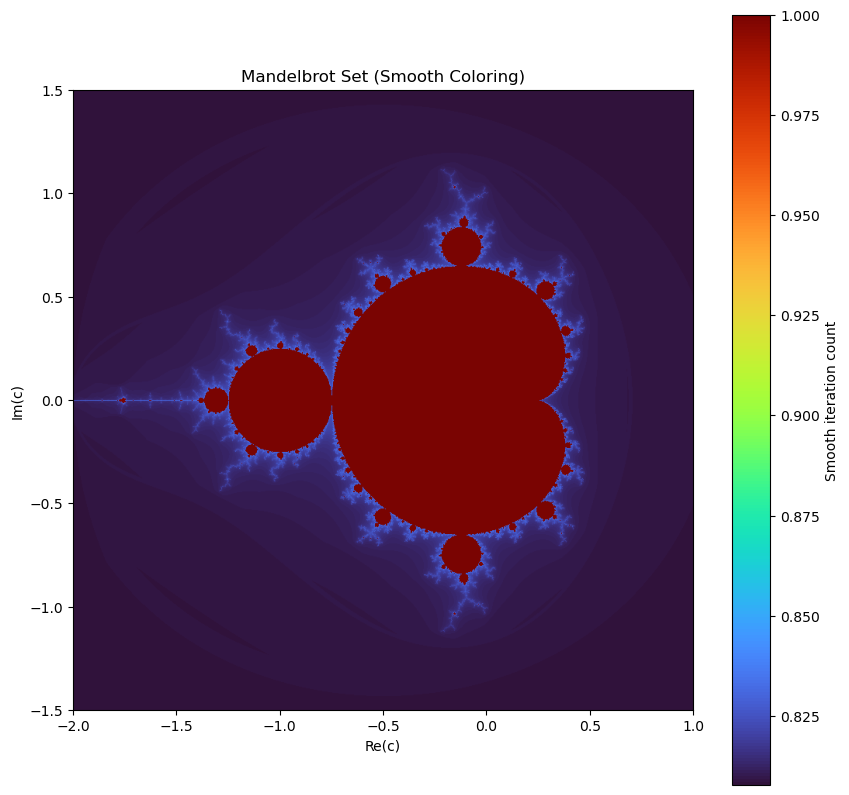

CPU times: user 4.21 s, sys: 630 ms, total: 4.84 s
Wall time: 1.17 s


In [73]:
%%time

# Parameters
res = 800
width, height = res, res
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
#zoom = 	78125
#delta = 2 / zoom
#center = -0.761574,-0.0847596
#x_min, y_min = center[0] - delta, center[1] - delta
#x_max, y_max = center[0] + delta, center[1] + delta
max_iter = 10000

# Compute
mandelbrot_image = mandelbrot_smooth_optimized(width, height, x_min, x_max, y_min, y_max, max_iter)

# Equalize smooth values
mandelbrot_eq = equalize_histogram(mandelbrot_image)

# Plot with smooth color gradient
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_eq, extent=(x_min, x_max, y_min, y_max), cmap='turbo')
plt.colorbar(label="Smooth iteration count")
plt.title("Mandelbrot Set (Smooth Coloring)")
plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.show()


In [79]:
from numba import jit, prange
import numpy as np
import math

@jit(nopython=True, parallel=True, fastmath=True)
def mandelbrot_smooth_with_grid_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter,
    grid_spacing
):
    result = np.zeros((height, width), dtype=np.float32)
    trap = np.full((height, width), np.inf, dtype=np.float32)  # min distance trap

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height
    log2 = math.log(2.0)

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0
            min_dist = 1e10

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2

                # Distance to nearest vertical grid line
                dx_mod = zr % grid_spacing
                dx = min(dx_mod, grid_spacing - dx_mod)

                # Distance to nearest horizontal grid line
                dy_mod = zi % grid_spacing
                dy = min(dy_mod, grid_spacing - dy_mod)

                dist = min(dx, dy)

                if dist < min_dist:
                    min_dist = dist

                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n

            trap[y, x] = min_dist

    return result, trap


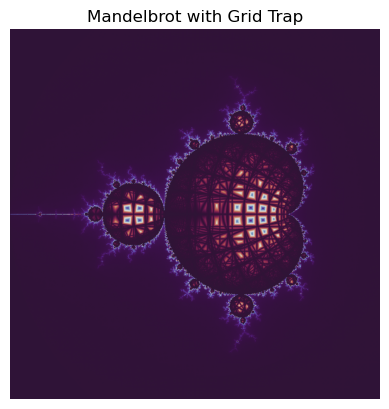

CPU times: user 777 ms, sys: 299 ms, total: 1.08 s
Wall time: 200 ms


In [81]:
%%time

width, height = 800, 800
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iter = 256
grid_spacing = 0.1  # smaller for finer grids

mandelbrot_img, grid_trap = mandelbrot_smooth_with_grid_trap(
    width, height, x_min, x_max, y_min, y_max, max_iter, grid_spacing
)

# Normalize for display
img_norm = (mandelbrot_img - mandelbrot_img.min()) / (mandelbrot_img.max() - mandelbrot_img.min())
trap_norm = 1 - (grid_trap - grid_trap.min()) / (grid_trap.max() - grid_trap.min())

blended = img_norm * trap_norm

import matplotlib.pyplot as plt
plt.imshow(blended, cmap='twilight_shifted', extent=(x_min, x_max, y_min, y_max))
plt.title("Mandelbrot with Grid Trap")
plt.axis('off')
plt.show()
